In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from nld_utils import calculate_fnn_stat, embed_signal, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Van der Pol Oscillator

$$\dot x = y\\
{\displaystyle {\dot {y}}=\mu (1-x^{2})y-x}.$$

In [3]:
def RK4(func, t0, y0, t_bound, dt=0.1, verbose=False):
    y_vals = np.zeros((int(t_bound/dt), len(y0)))
    t_vals = np.arange(y_vals.shape[0])*dt
    t = t0
    y = y0
    y_vals[0] = y
    for i, t in tqdm(enumerate(t_vals), disable=not verbose, total=len(t_vals)):
        k1 = func(t, y)
        k2 = func(t + dt/2, y + dt*k1/2)
        k3 = func(t + dt/2, y + dt*k2/2)
        k4 = func(t + dt, y + dt*k3)
        y += (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt
        y_vals[i] = y
    
    return y_vals, t_vals

In [4]:
indices = np.arange(2)
signals = {}
signal_analysis = {}

# total_time = 250 # s
total_time = 1000 # s
dt = 0.05
subsample_step = 1
T = int(total_time/dt)
# mu_vals = [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
mu_vals = [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5]
for mu in tqdm(mu_vals):
    x0 = np.random.randn()*2
    y0 = np.random.randn()*2
#     x0 = 0
#     y0 = 1

    # ------------
    # EULER
    # -----------
#     x = np.zeros(T)
#     y = np.zeros(T)
    
#     x[0] = x0
#     y[0] = y0
#     for t in range(1, T):
#         x[t] = x[t - 1] + dt*(y[t - 1])
#         y[t] = y[t - 1] + dt*(mu*(1 - x[t-1]**2)*y[t-1] - x[t-1])

#     data = np.vstack([x, y]).T
    
    # ------------
    # RUNGE KUTTA
    # -----------
    dynamic_noise_sd = 0.8
    y, t = RK4(lambda t, v: np.array([v[1] + np.random.randn()*dynamic_noise_sd, mu*(1 - v[0]**2)*v[1] - v[0] + np.random.randn()*dynamic_noise_sd]), 0, (np.random.randn()*2, np.random.randn()*2), t_bound=total_time, dt=dt, verbose=False)
    data = y
    
    signals[f"mu = {mu}"] = data[np.arange(0, data.shape[0], subsample_step)]
        
signal_analysis = {}

  0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
signal_analysis = {}

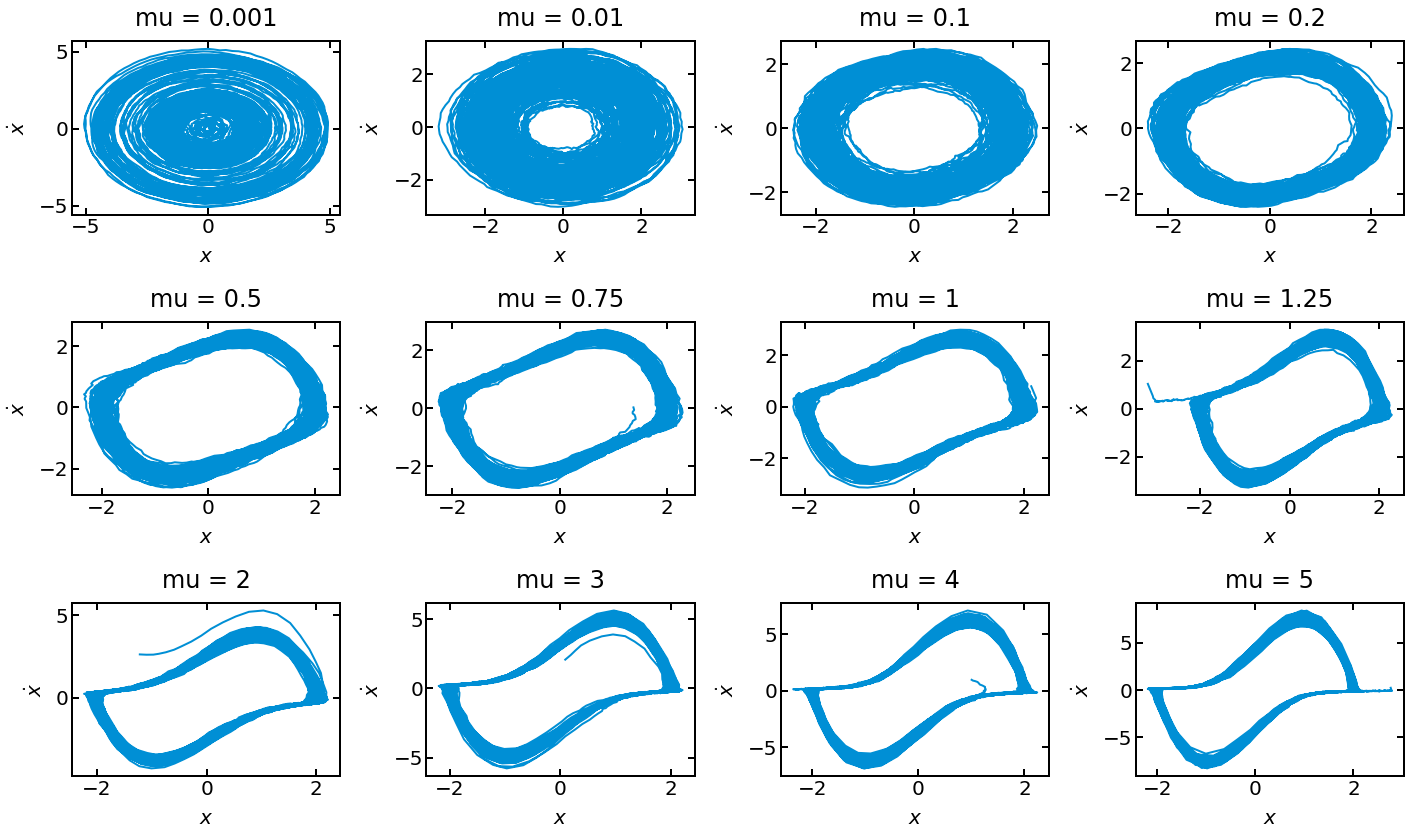

In [6]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))

for i, (key, signal) in enumerate(signals.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    ax.plot(signal[:, 0], signal[:, 1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    ax.set_title(f"{key}")
plt.tight_layout()
plt.show()

# Load Neural Data 

In [7]:
session = 'Mary-Anesthesia-20160912-02'

In [8]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [9]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [10]:
spike_times = spike_times[0]

# Analyze

In [428]:
window = 4000 # ms 
# start_time = 4000 # ms
start_time = 55*60*1000 # ms
indices = np.where(electrode_info['area'] == 'vlPFC')[0]

# signame = 'mu = 5'

In [429]:
# signal_in = signals[signame][:window]
signal_in = lfp[start_time:window + start_time, indices]
# signal_in = signal_in - signal_in.mean(axis=0)

In [430]:
N = signal_in.shape[1]

In [431]:
# A_VAR1 = compute_VAR_p(signal_in, p=1)['coefs'][0]
A_VAR1 = compute_VAR_p(signal_in, p=1)['coefs'][0]

In [432]:
delta = 1 # time steps lag
X = signal_in[:window - delta].T
X = np.vstack([X, np.ones(X.shape[1])])
Y = signal_in[delta:window].T

In [433]:
U, S, Vh = np.linalg.svd(X)
# X_new = U @ np.diag(S) @ Vh[:len(S)]
S_mat = np.zeros(X.shape)
S_mat[np.arange(N + 1), np.arange(N + 1)] = S
A_DMD = np.zeros((N, N, N))
# S_DMD = []
S_mat_eff = S_mat.copy()
for i in tqdm(range(N)):
    S_mat_eff[np.arange(N - i, N), np.arange(N - i, N)] = 0
    A_DMD[i] = (Y @ Vh.T @ np.linalg.pinv(S_mat_eff) @ U.T)[:, :-1]
#     S_DMD.append(U[:, :N-i].T @ Y @ Vh.T @ np.linalg.pinv(S_mat[:N-i]))

  0%|          | 0/64 [00:00<?, ?it/s]

In [434]:
# A_DMD_full = Y @ X.T @ np.linalg.inv(X @ X.T)
# G = np.zeros((N, N))
# A = np.zeros((N, N))
# M = X.shape[1]
# for m in range(M):
#     G += np.outer(X[:, m], X[:, m])
#     A += np.outer(X[:, m], Y[:, m])
# G /= M
# A /= M
# A_DMD_full2 = np.linalg.pinv(G) @ A
# plt.plot(np.sort(np.abs(np.linalg.eigvals(A_DMD_full))))
# plt.plot(np.sort(np.abs(np.linalg.eigvals(A_DMD_full2))))
# plt.show()

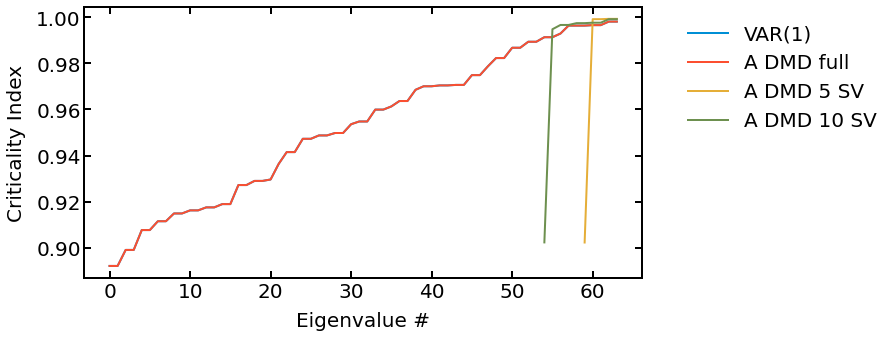

In [435]:
plt.plot(np.sort(np.abs(np.linalg.eigvals(A_VAR1))), label='VAR(1)')
plt.plot(np.sort(np.abs(np.linalg.eigvals(A_DMD[0]))), label='A DMD full')
# plt.plot(np.sort(np.abs(np.linalg.eigvals(S_DMD[0]))), label='S DMD full')
# svs = [5, 10, 15, 20, 25]
svs = [5, 10]
for i in svs:
    plt.plot(np.arange(N - i, N), np.sort(np.abs(np.linalg.eigvals(A_DMD[N - i])))[-i:], label=f'A DMD {i} SV')
#     plt.plot(np.arange(N - i, N), np.sort(np.abs(np.linalg.eigvals(S_DMD[N - i]))), label=f'S DMD {i} SV')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Eigenvalue #')
plt.ylabel('Criticality Index')
plt.show()

## VAR(p)

In [436]:
def construct_A_mat(coefs):
    p = coefs.shape[0]
    N = coefs.shape[1]
    A_mat = np.zeros((N*p, N*p))
    for i in range(p):
        A_mat[0:N, :][:, i*N:(i + 1)*N] = coefs[i]
        if i < p - 1:
            A_mat[(i + 1)*N:(i + 2)*N][:, i*N:(i + 1)*N] = np.eye(N)
            
    return A_mat

In [437]:
A_VAR_p = []
A_DMD_p = []
for p in range(1, 7):
    A_VAR_p.append(construct_A_mat(compute_VAR_p(signal_in, p=p)['coefs']))

    X_p = np.zeros((N*p + 1, window - p))
    Y_p = np.zeros((N*p, window - p))
    for t in range(window - p):
        for i in range(p):
            X_p[i*N:(i + 1)*N, t] = signal_in[t + p - 1 - i]
            Y_p[i*N:(i + 1)*N, t] = signal_in[t + p - i]
    X_p[-1] = np.ones(window - p)
    U, S, Vh = np.linalg.svd(X_p)
    S_mat = np.zeros((N*p + 1, window - p))
    S_mat[np.arange(N*p + 1), np.arange(N*p + 1)] = S
    A_DMD_p.append((Y_p @ Vh.T @ np.linalg.pinv(S_mat) @ U.T)[:, :-1])

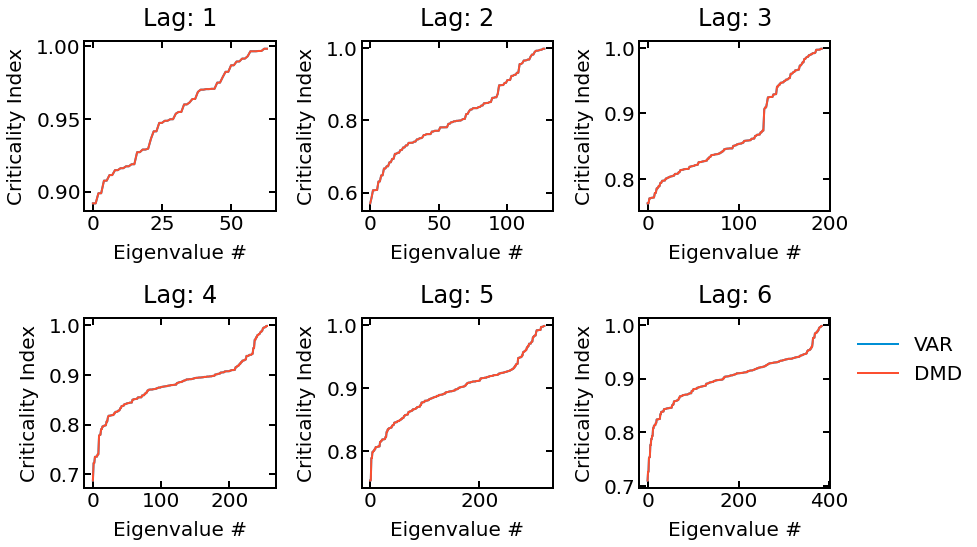

In [438]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
for p in range(1, 7):
    ax = axs[int((p - 1)/3)][(p - 1) % 3]
    ax.plot(np.sort(np.abs(np.linalg.eigvals(A_VAR_p[p - 1]))), label=f'VAR')
    ax.plot(np.sort(np.abs(np.linalg.eigvals(A_DMD_p[p - 1]))), label=f'DMD')
    ax.set_title(f'Lag: {p}')
    ax.set_xlabel('Eigenvalue #')
    ax.set_ylabel('Criticality Index')
# plt.plot(np.sort(np.abs(np.linalg.eigvals(S_DMD[0]))), label='S DMD full')
# svs = [5, 10, 15, 20, 25]
# svs = [5, 10]
# for i in svs:
#     plt.plot(np.arange(N - i, N), np.sort(np.abs(np.linalg.eigvals(A_DMD[N - i])))[-i:], label=f'A DMD {i} SV')
#     plt.plot(np.arange(N - i, N), np.sort(np.abs(np.linalg.eigvals(S_DMD[N - i]))), label=f'S DMD {i} SV')
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Regularization

In [439]:
p = 15
X_p = np.zeros((N*p + 1, window - p))
Y_p = np.zeros((N*p, window - p))
for t in range(window - p):
    for i in range(p):
        X_p[i*N:(i + 1)*N, t] = signal_in[t + p - 1 - i]
        Y_p[i*N:(i + 1)*N, t] = signal_in[t + p - i]
X_p[-1] = np.ones(window - p)
U, S, Vh = np.linalg.svd(X_p)
S_mat = np.zeros((N*p + 1, window - p))
S_mat[np.arange(N*p + 1), np.arange(N*p + 1)] = S

In [442]:
# lambda_vals = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]
# lambda_vals = np.hstack([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.05), np.arange(1, 2.01, 0.1)])
lambda_vals = np.hstack([[0], np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.05), np.arange(1, 2.01, 0.1)])
# lambda_vals = [0, 0.01]
# lambda_vals = np.hstack([[0], np.arange(0.001, 0.01, 0.001)])
all_coefs = np.zeros((len(lambda_vals), p, N, N))
intercepts = np.zeros((len(lambda_vals), N))
# S_mat_cov = S_mat.T @ S_mat
# right_side = S_mat.T @ U.T
S_mat_inv = S_mat.copy().T
left_side = Y_p[:N] @ Vh.T
for i, lamb in tqdm(enumerate(lambda_vals), total=len(lambda_vals)):
    if lamb == 0:
#         full_mat = Y_p[:N] @ Vh.T @ np.linalg.pinv(S_mat) @ U.T
        ret = compute_VAR_p(signal_in, p=p)
        all_coefs[i] = ret['coefs']
        intercepts[i] = ret['intercept']
    else:
#         full_mat = left_side @ np.linalg.inv(S_mat_cov + lamb*np.eye(S_mat.shape[1])) @ right_side
        S_mat_inv[np.arange(N*p + 1), np.arange(N*p + 1)] = S/(S**2 + lamb)
        full_mat = left_side @ S_mat_inv @ U.T
        intercepts[i] = full_mat[:, -1]
        coefs = np.zeros((p, N, N))
        for j in range(p):
            coefs[j] = full_mat[:, j*N:(j + 1)*N]
        all_coefs[i] = coefs

  0%|          | 0/48 [00:00<?, ?it/s]

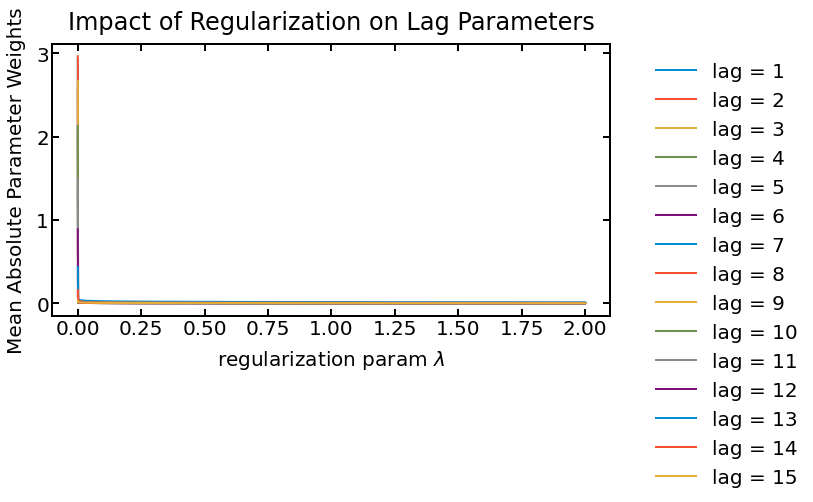

In [443]:
mean_absolute_params = np.abs(all_coefs).mean(axis=2).mean(axis=2)
for i in range(p):
    plt.plot(lambda_vals, mean_absolute_params[:, i], label=f'lag = {i + 1}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r"regularization param $\lambda$")
plt.title('Impact of Regularization on Lag Parameters')
plt.ylabel('Mean Absolute Parameter Weights')
plt.show()

### Prediction

In [444]:
T_pred = 25

In [445]:
pred_data = lfp[start_time + window - p:start_time + window + T_pred, indices]
predictions = np.zeros((len(lambda_vals), T_pred, N))
mses = np.zeros(len(lambda_vals))
for i, lamb in enumerate(tqdm(lambda_vals)):
    preds, true_vals = predict_VAR_p(pred_data, all_coefs[i], intercepts[i])
    predictions[i] = preds
    mses[i] = ((preds - true_vals)**2).mean()

  0%|          | 0/48 [00:00<?, ?it/s]

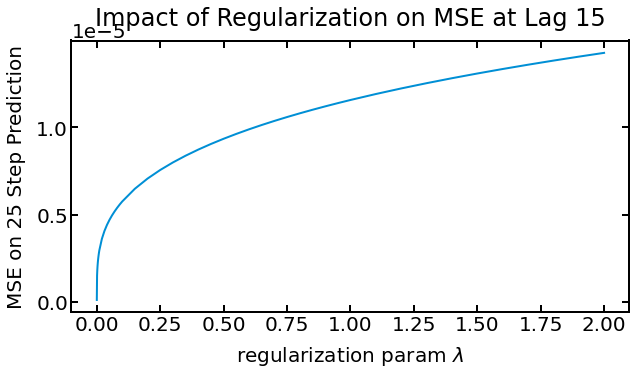

In [446]:
plt.plot(lambda_vals, mses)
plt.xlabel(r"regularization param $\lambda$")
plt.title(f'Impact of Regularization on MSE at Lag {p}')
plt.ylabel(f"MSE on {T_pred} Step Prediction")
plt.show()

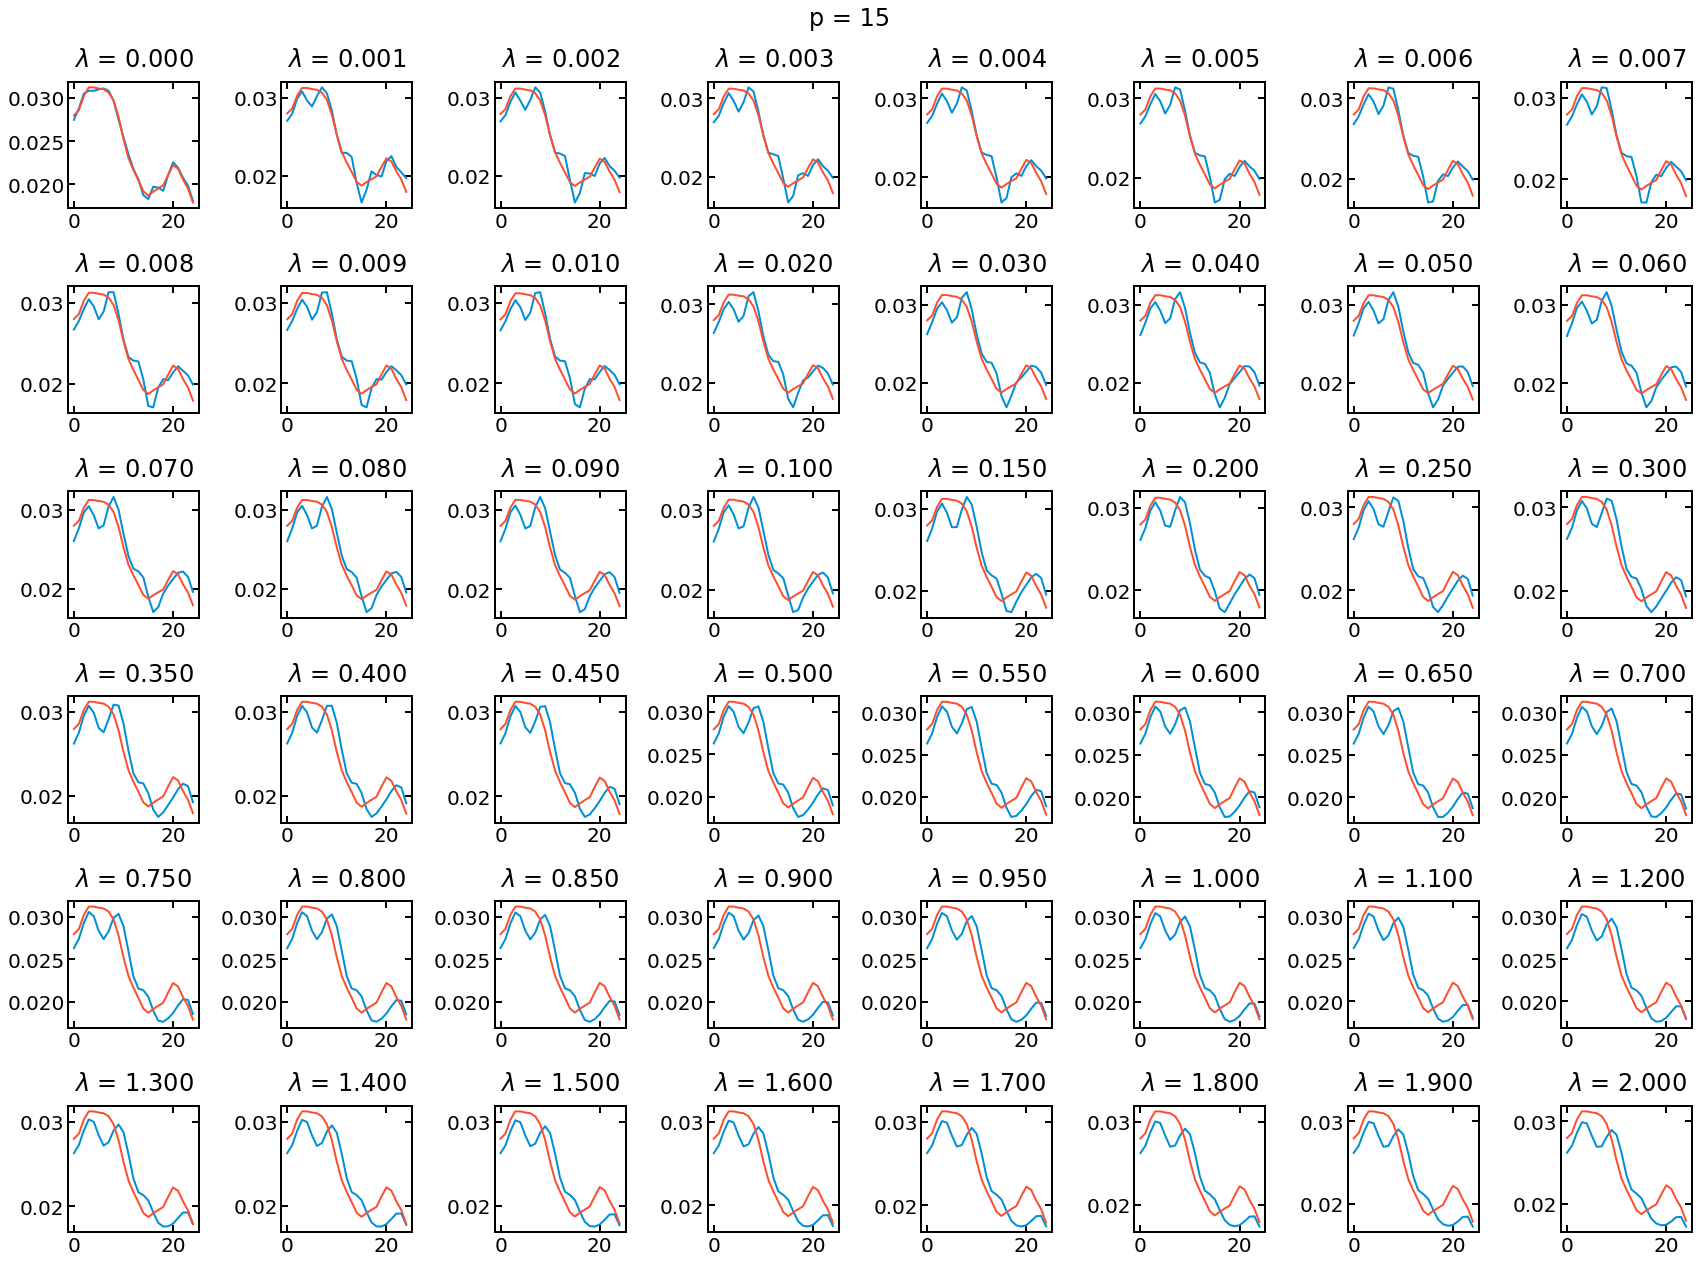

In [447]:
unit_num = 0
fig, axs = plt.subplots(6, 8, figsize=(24, 18))
for i, lamb in enumerate(lambda_vals):
    ax = axs[int(i/8)][i % 8]
    ax.plot(predictions[i][:, unit_num])
    ax.plot(true_vals[:, 0])
    ax.set_title(r"$\lambda$ = " + f"{lamb:.3f}")
plt.suptitle(f'p = {p}')
plt.tight_layout()
plt.show()

# TOMORROW: look at the actual dynamic MODES (keep reading)

# WHAT WAS THAT THING I WANTED TO TRY?
- compare to the Antonio Costa paper worms match their exponent distribution
- find a principled way of computing the range for window sizes (and maybe lags?) - min and max window sizes should be functions of max lag, N, and dt of course)
    - range over which it's locally linear? use correlation dimension to show this?